In [6]:
import os
import cv2
import numpy as np

# Path to the folder containing the ground truth images
data_dir = r'C:\Users\Babak\Desktop\Automated_Dural_sack_measurement\05_Final_Ground_Truth_Data\Label_Images'

# Path to the folder where the binary masks for the TS region will be saved
output_dir = r'C:\Users\Babak\Desktop\Automated_Dural_sack_measurement\Output_TS'

# Define the color range to extract (in this case, the TS color)
lower_range = np.array([150, 150, 150])
upper_range = np.array([150, 150, 150])

# HEX and RGB values for the TS region
TS_HEX = '#969696' # got for example through https://imagecolorpicker.com/
TS_RGB = (150, 150, 150) # got for example through https://imagecolorpicker.com/

# Loop through each image in the ground truth folder
for filename in os.listdir(data_dir):
    # Load the image
    img = cv2.imread(os.path.join(data_dir, filename))

    # Create a binary mask with only the TS pixels
    mask = cv2.inRange(img, lower_range, upper_range)

    # Apply the mask to the original image
    ts_img = cv2.bitwise_and(img, img, mask=mask)


    # Save the binary mask in the output folder with the same filename
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, ts_img)

In [20]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Preprocessing
def preprocess(img):
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

def load_data(data_dir, label_dir):
    x_train, y_train = [], []
    for filename in os.listdir(data_dir):
        if filename.endswith('.png') and filename.startswith('T1'):
            # Load the image
            img = cv2.imread(os.path.join(data_dir, filename), cv2.IMREAD_GRAYSCALE)

            # Load the corresponding label image
            label_filename = filename.replace('T1', 'L1')
            label_img = cv2.imread(os.path.join(label_dir, label_filename), cv2.IMREAD_GRAYSCALE)

            # Preprocess the input and label images
            img = preprocess(img)
            label_img = preprocess(label_img)

            # Normalize the label image
            label_img = np.where(label_img == 150/255, 1.0, 0.0)

            # Append the images to the lists
            x_train.append(img)
            y_train.append(label_img)
    
    return np.array(x_train), np.array(y_train)

import tensorflow.keras.backend as K

def weighted_binary_crossentropy(pos_weight, neg_weight):
    def _weighted_binary_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * pos_weight + (1. - y_true) * neg_weight
        weighted_bce = weight_vector * bce
        return K.mean(weighted_bce)
    return _weighted_binary_crossentropy

# Set the weights for positive and negative classes
pos_weight = 20.0
neg_weight = 1.0

# U-Net model
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    # Compile the model with the custom loss function
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy(pos_weight, neg_weight), metrics=['accuracy'])

    return model



# Train the model
data_dir = r'C:\Users\Babak\Desktop\Automated_Dural_sack_measurement\04_Intermediary_Ground_Truth_Data\T1_Output'
label_dir = r'C:\Users\Babak\Desktop\Automated_Dural_sack_measurement\Output_TS'

x_train, y_train = load_data(data_dir, label_dir)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Add channel dimension
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

x_val = np.expand_dims(x_val, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

model = unet_model()

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint('unet_dural_sack.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[model_checkpoint]
)

Epoch 1/20
39/39 [==============================] - 89s 2s/step - loss: 0.2769 - accuracy: 0.9723 - val_loss: 0.1303 - val_accuracy: 0.9972
Epoch 2/20
39/39 [==============================] - 79s 2s/step - loss: 0.1262 - accuracy: 0.9972 - val_loss: 0.0989 - val_accuracy: 0.9972
Epoch 3/20
39/39 [==============================] - 78s 2s/step - loss: 0.0631 - accuracy: 0.9900 - val_loss: 0.0435 - val_accuracy: 0.9860
Epoch 4/20
39/39 [==============================] - 79s 2s/step - loss: 0.0265 - accuracy: 0.9938 - val_loss: 0.0207 - val_accuracy: 0.9967
Epoch 5/20
39/39 [==============================] - 79s 2s/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.0159 - val_accuracy: 0.9969
Epoch 6/20
39/39 [==============================] - 79s 2s/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 0.0155 - val_accuracy: 0.9948
Epoch 7/20
39/39 [==============================] - 80s 2s/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 0.0120 - val_accuracy: 0.9973
Epoch 8/20
39/39 [==

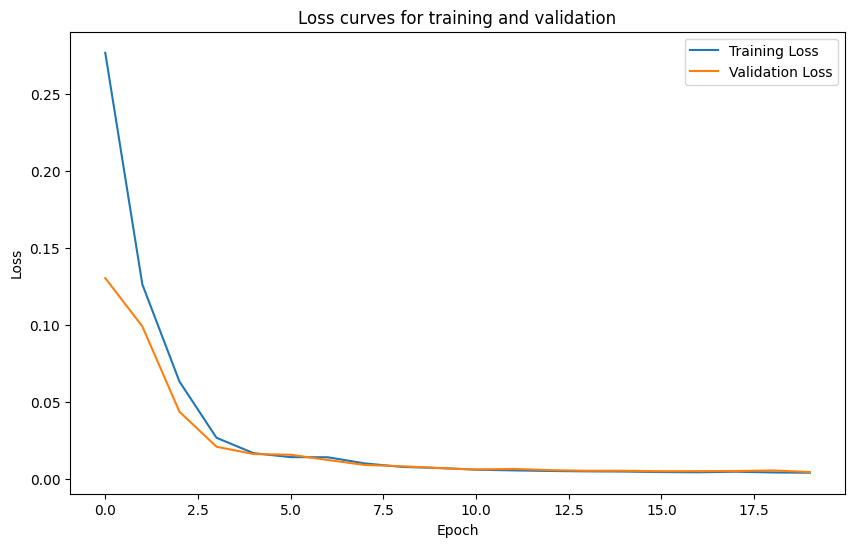

In [21]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for training and validation')
plt.legend()
plt.show()

In [71]:
# Set the weights for positive and negative classes
pos_weight = 10.0
neg_weight = 1.0

10/10 [==============================] - 4s 434ms/step
Accuracy: 0.9990
Precision: 0.7406
Recall: 0.9923
F1-score: 0.8482


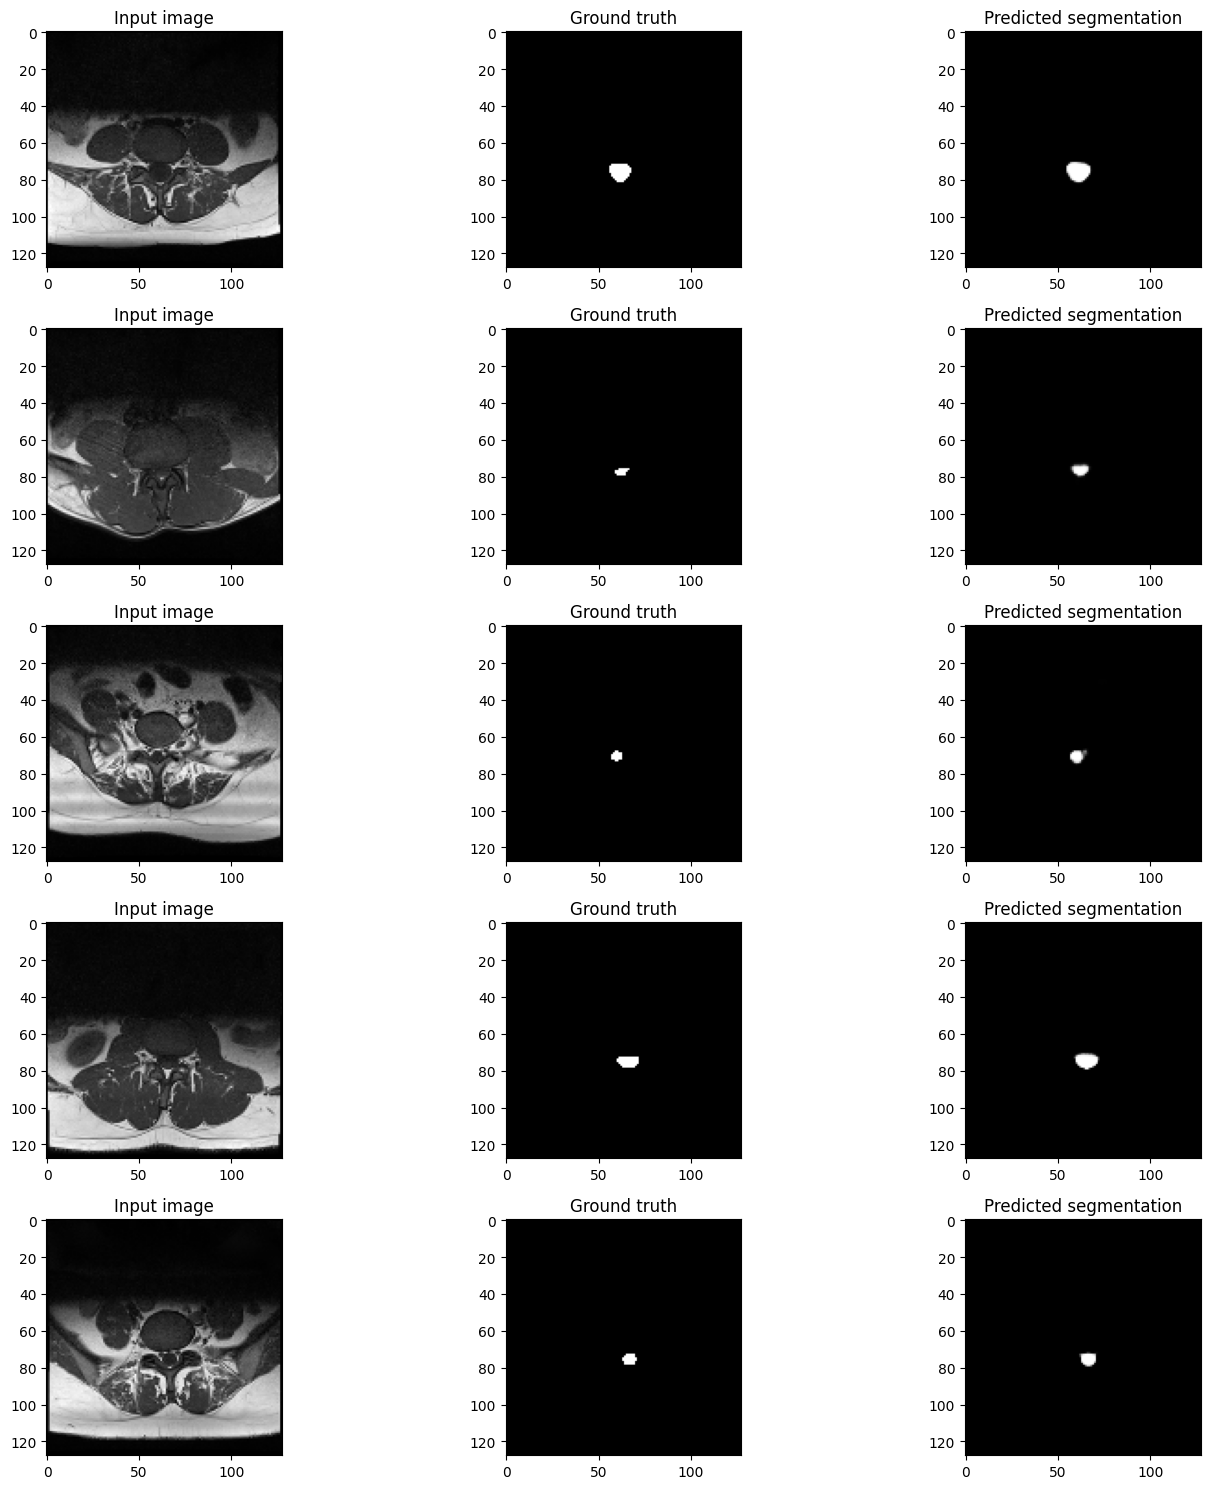

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load the trained model with the custom loss function
model = tf.keras.models.load_model('unet_dural_sack.h5', custom_objects={'_weighted_binary_crossentropy': weighted_binary_crossentropy(pos_weight, neg_weight)})


# Predict on the validation set
y_pred = model.predict(x_val)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate performance metrics
accuracy = accuracy_score(y_val.flatten(), y_pred_binary.flatten())
precision = precision_score(y_val.flatten(), y_pred_binary.flatten())
recall = recall_score(y_val.flatten(), y_pred_binary.flatten())
f1 = f1_score(y_val.flatten(), y_pred_binary.flatten())

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Visualize some predictions
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))

for i in range(num_images):
    axes[i, 0].imshow(x_val[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title("Input image")
    axes[i, 1].imshow(y_val[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title("Ground truth")
    axes[i, 2].imshow(y_pred[i, :, :, 0], cmap='gray')
    axes[i, 2].set_title("Predicted segmentation")

plt.tight_layout()
plt.show()

Mean Absolute Error: 7.4921 mm²
Mean Squared Error: 74.9509 mm²


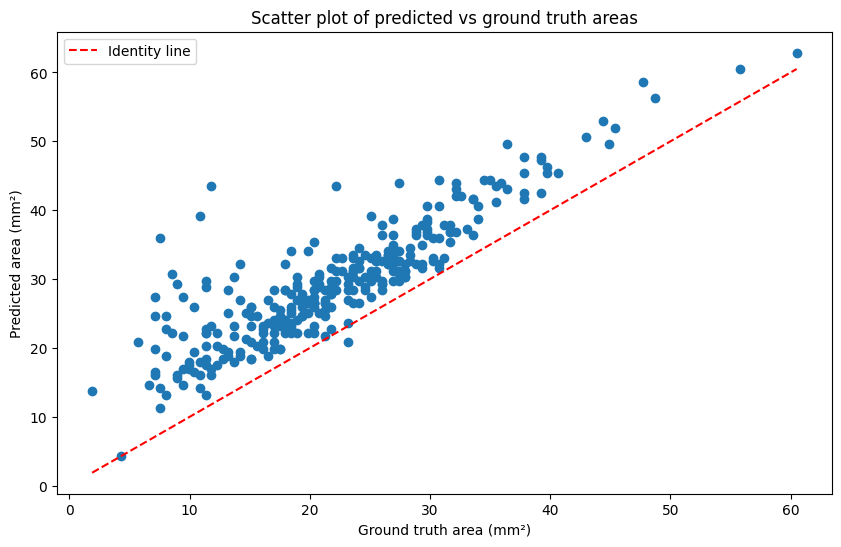

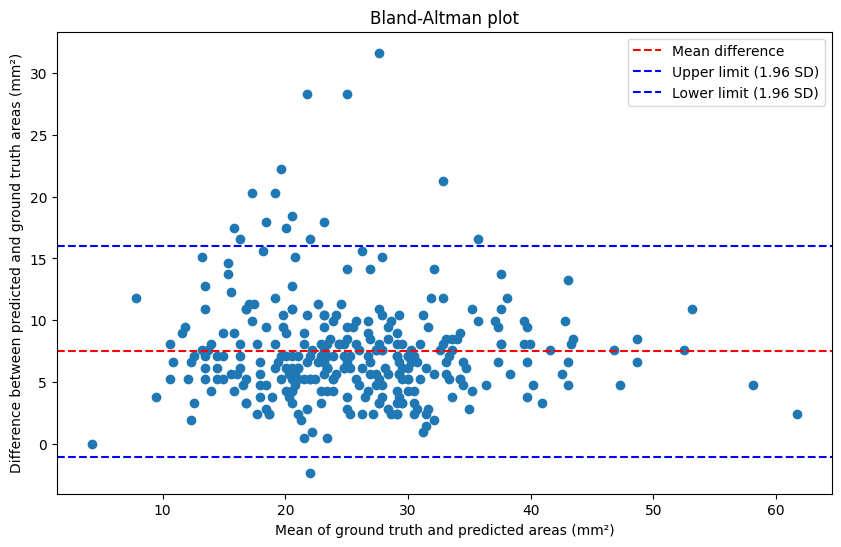

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set the pixel size in mm
pixel_size_mm = 0.6875  # Adjust this value according to your image resolution. This corresponds to Image Spacing information in 3D slicer Volumes module

# Calculate the dural sack cross-sectional area for each image
def calculate_areas(mask, pixel_size):
    areas = []
    for m in mask:
        area = np.sum(m) * pixel_size**2
        areas.append(area)
    return np.array(areas)

# Calculate areas for predicted and ground truth masks
areas_pred = calculate_areas(y_pred_binary, pixel_size_mm)
areas_gt = calculate_areas(y_val, pixel_size_mm)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(areas_gt, areas_pred)
mse = mean_squared_error(areas_gt, areas_pred)
print(f"Mean Absolute Error: {mae:.4f} mm²")
print(f"Mean Squared Error: {mse:.4f} mm²")

# Visualize the results with a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(areas_gt, areas_pred)
plt.xlabel('Ground truth area (mm²)')
plt.ylabel('Predicted area (mm²)')
plt.title('Scatter plot of predicted vs ground truth areas')
plt.plot([min(areas_gt), max(areas_gt)], [min(areas_gt), max(areas_gt)], 'r--', label='Identity line')
plt.legend()
plt.show()

# Bland-Altman plot
mean_diff = np.mean(areas_pred - areas_gt)
std_diff = np.std(areas_pred - areas_gt)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

plt.figure(figsize=(10, 6))
plt.scatter((areas_gt + areas_pred) / 2, areas_pred - areas_gt)
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean difference')
plt.axhline(upper_limit, color='blue', linestyle='--', label='Upper limit (1.96 SD)')
plt.axhline(lower_limit, color='blue', linestyle='--', label='Lower limit (1.96 SD)')
plt.xlabel('Mean of ground truth and predicted areas (mm²)')
plt.ylabel('Difference between predicted and ground truth areas (mm²)')
plt.title('Bland-Altman plot')
plt.legend()
plt.show()

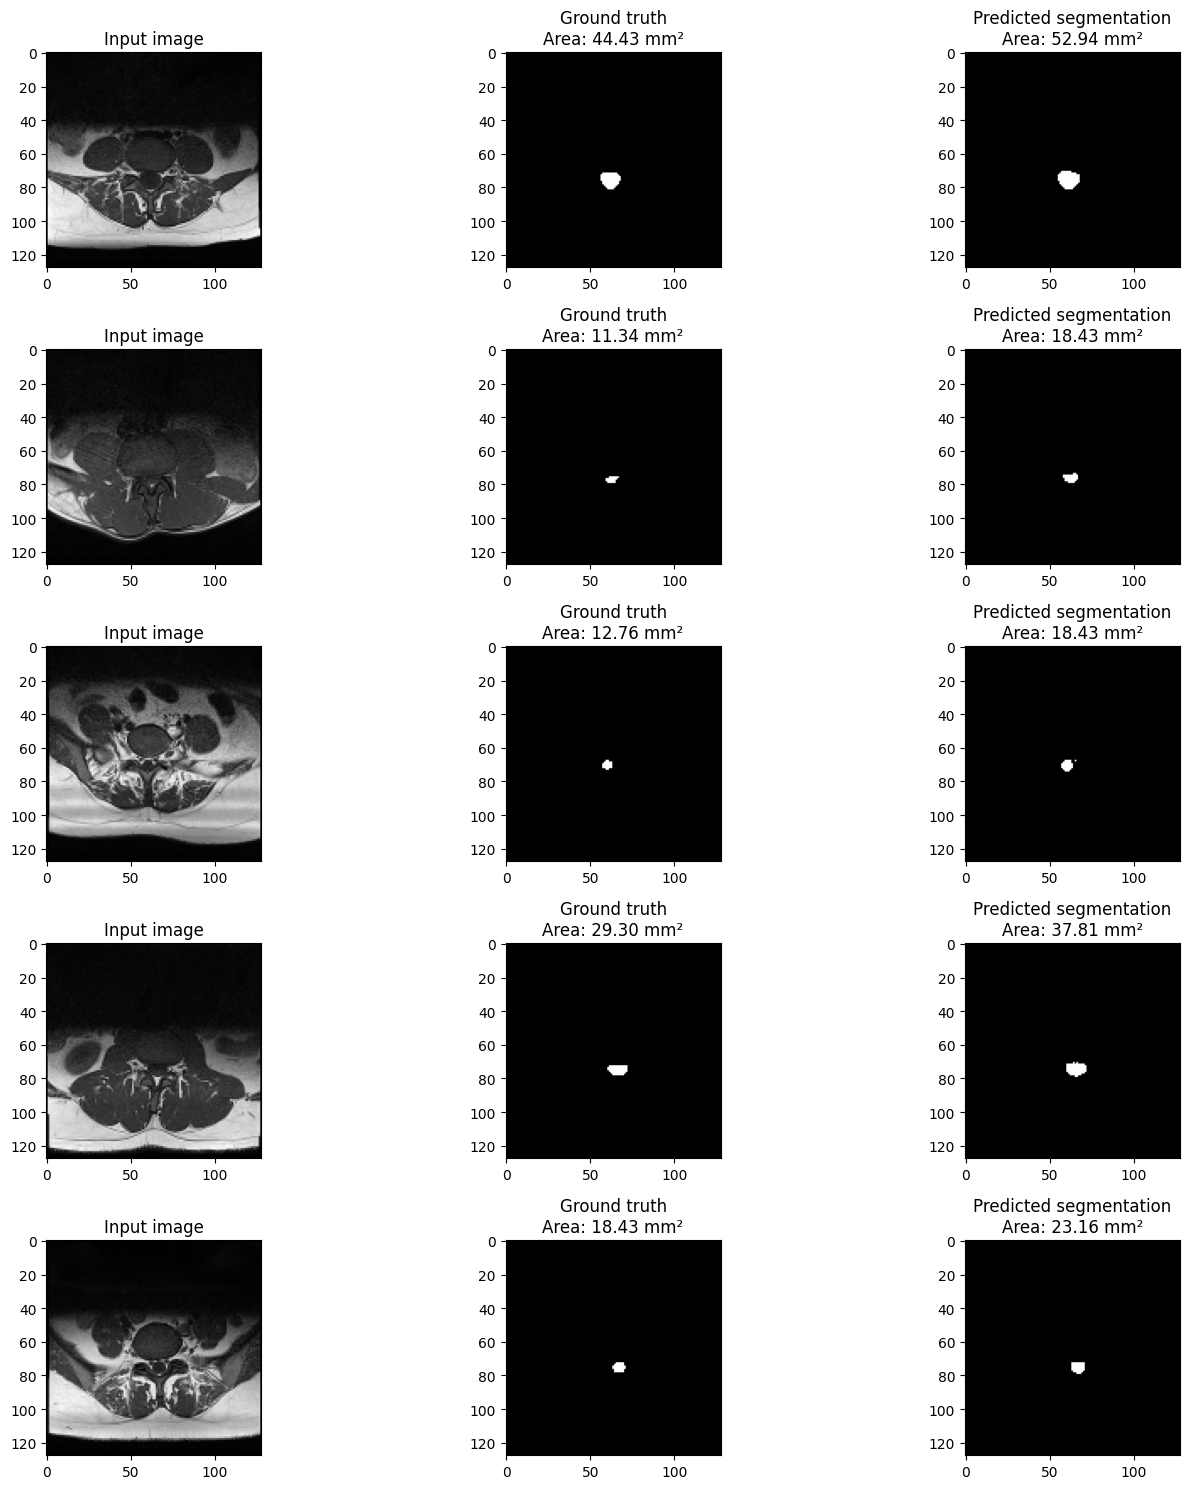

In [24]:
import matplotlib.pyplot as plt

pixel_size_mm = 0.6875

def calculate_area(mask, pixel_size_mm):
    num_pixels = np.sum(mask)
    return num_pixels * (pixel_size_mm ** 2)

# Visualize some predictions with cross-sectional area
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))

for i in range(num_images):
    predicted_area = calculate_area(y_pred_binary[i, :, :, 0], pixel_size_mm)
    gt_area = calculate_area(y_val[i, :, :, 0], pixel_size_mm)
    axes[i, 0].imshow(x_val[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title("Input image")
    axes[i, 1].imshow(y_val[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title(f"Ground truth\nArea: {gt_area:.2f} mm²")
    axes[i, 2].imshow(y_pred_binary[i, :, :, 0], cmap='gray')
    axes[i, 2].set_title(f"Predicted segmentation\nArea: {predicted_area:.2f} mm²")

plt.tight_layout()
plt.show()

In [3]:
import os
import cv2
import numpy as np
import SimpleITK as sitk

def preprocess(img):
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

def load_data(data_dir, label_dir):
    x_train, y_train = [], []

    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.nrrd'):
            continue

        # Extract patient ID from label filename
        patient_id = label_file[:4]

        # Find matching non-segmented file in data_dir
        data_file = os.path.join(data_dir, f'{patient_id}.dcm.nrrd')
        if not os.path.exists(data_file):
            continue

        # Read segmentation mask
        label_file = os.path.join(label_dir, label_file)
        label_img_sitk = sitk.ReadImage(label_file)
        label_img_np = sitk.GetArrayFromImage(label_img_sitk)

        for slice_index in range(label_img_np.shape[0]):
            # Check if segmentation is present for this slice
            if np.sum(label_img_np[slice_index]) == 0:
                continue

            # Read axial slice from NRRD
            img_sitk = sitk.ReadImage(data_file)
            img_np = sitk.GetArrayFromImage(img_sitk)
            img = img_np[slice_index]

            # Get corresponding segmentation mask slice
            label_slice = label_img_np[slice_index]

            # Preprocess the input and label images
            img = preprocess(img)
            label_slice = preprocess(label_slice)

            # Normalize the label image
            label_slice = np.where(label_slice > 0, 1.0, 0.0)

            # Append the images to the lists
            x_train.append(img)
            y_train.append(label_slice)

    return np.array(x_train), np.array(y_train)

# Train the model
data_dir = r'C:\Users\Babak\Desktop\Automated_Dural_sack_measurement\own_study\non_segmented'
label_dir = r'C:\Users\Babak\Desktop\Automated_Dural_sack_measurement\own_study\segmented'

x_train, y_train = load_data(data_dir, label_dir)

In [ ]:
import matplotlib.pyplot as plt

num_images = 6
fig, axes = plt.subplots(num_images, 2, figsize=(15, 15))

for i in range(num_images):
    axes[i, 0].imshow(x_train[i], cmap='gray')
    axes[i, 0].set_title("Input image")
    axes[i, 1].imshow(y_train[i], cmap='gray')
    axes[i, 1].set_title("Ground truth")

plt.tight_layout()
plt.show()

In [5]:
# Set the weights for positive and negative classes
pos_weight = 10.0
neg_weight = 1.0

In [8]:
import tensorflow.keras.backend as K

def weighted_binary_crossentropy(pos_weight, neg_weight):
    def _weighted_binary_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * pos_weight + (1. - y_true) * neg_weight
        weighted_bce = weight_vector * bce
        return K.mean(weighted_bce)
    return _weighted_binary_crossentropy

In [13]:
y_train.shape

(279, 128, 128)

In [14]:
x_train.shape

(279, 128, 128)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf


# Load the trained model with the custom loss function
model = tf.keras.models.load_model('unet_dural_sack.h5', custom_objects={'_weighted_binary_crossentropy': weighted_binary_crossentropy(pos_weight, neg_weight)})


# Predict on the validation set
y_pred = model.predict(x_train)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate performance metrics
accuracy = accuracy_score(y_train.flatten(), y_pred_binary.flatten())
precision = precision_score(y_train.flatten(), y_pred_binary.flatten())
recall = recall_score(y_train.flatten(), y_pred_binary.flatten())
f1 = f1_score(y_train.flatten(), y_pred_binary.flatten())

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Visualize some predictions
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))

for i in range(num_images):
    axes[i, 0].imshow(x_train[i, :, :], cmap='gray')
    axes[i, 0].set_title("Input image")
    axes[i, 1].imshow(y_train[i, :, :], cmap='gray')
    axes[i, 1].set_title("Ground truth")
    axes[i, 2].imshow(y_pred[i, :, :, 0], cmap='gray')
    axes[i, 2].set_title("Predicted segmentation")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set the pixel size in mm
pixel_size_mm = 0.5357  # Adjust this value according to your image resolution. This corresponds to Image Spacing information in 3D slicer Volumes module

# Calculate the dural sack cross-sectional area for each image
def calculate_areas(mask, pixel_size):
    areas = []
    for m in mask:
        area = np.sum(m) * pixel_size**2
        areas.append(area)
    return np.array(areas)

# Calculate areas for predicted and ground truth masks
areas_pred = calculate_areas(y_pred_binary, pixel_size_mm)
areas_gt = calculate_areas(y_train, pixel_size_mm)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(areas_gt, areas_pred)
mse = mean_squared_error(areas_gt, areas_pred)
print(f"Mean Absolute Error: {mae:.4f} mm²")
print(f"Mean Squared Error: {mse:.4f} mm²")

# Visualize the results with a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(areas_gt, areas_pred)
plt.xlabel('Ground truth area (mm²)')
plt.ylabel('Predicted area (mm²)')
plt.title('Scatter plot of predicted vs ground truth areas')
plt.plot([min(areas_gt), max(areas_gt)], [min(areas_gt), max(areas_gt)], 'r--', label='Identity line')
plt.legend()
plt.show()

# Bland-Altman plot
mean_diff = np.mean(areas_pred - areas_gt)
std_diff = np.std(areas_pred - areas_gt)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

plt.figure(figsize=(10, 6))
plt.scatter((areas_gt + areas_pred) / 2, areas_pred - areas_gt)
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean difference')
plt.axhline(upper_limit, color='blue', linestyle='--', label='Upper limit (1.96 SD)')
plt.axhline(lower_limit, color='blue', linestyle='--', label='Lower limit (1.96 SD)')
plt.xlabel('Mean of ground truth and predicted areas (mm²)')
plt.ylabel('Difference between predicted and ground truth areas (mm²)')
plt.title('Bland-Altman plot')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

pixel_size_mm = 0.5357

def calculate_area(mask, pixel_size_mm):
    num_pixels = np.sum(mask)
    return num_pixels * (pixel_size_mm ** 2)

# Visualize some predictions with cross-sectional area
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))

for i in range(num_images):
    predicted_area = calculate_area(y_pred_binary[i, :, :, 0], pixel_size_mm)
    gt_area = calculate_area(y_train[i, :, :], pixel_size_mm)
    axes[i, 0].imshow(x_train[i, :, :], cmap='gray')
    axes[i, 0].set_title("Input image")
    axes[i, 1].imshow(y_train[i, :, :], cmap='gray')
    axes[i, 1].set_title(f"Ground truth\nArea: {gt_area:.2f} mm²")
    axes[i, 2].imshow(y_pred_binary[i, :, :], cmap='gray')
    axes[i, 2].set_title(f"Predicted segmentation\nArea: {predicted_area:.2f} mm²")

plt.tight_layout()
plt.show()